In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Load and display MNIST handwritten digits dataset

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array.
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [ ]:
# Check how many images are there for each digit
for j in np.arange(10):
    idx = np.where(y==str(j))
    idx = np.asarray(idx)[0,:]
    print('digit %i length %i' % (j, len(idx)))

digit 0 length 6903
digit 1 length 7877
digit 2 length 6990
digit 3 length 7141
digit 4 length 6824
digit 5 length 6313
digit 6 length 6876
digit 7 length 7293
digit 8 length 6825
digit 9 length 6958


In [ ]:
# Plot some sample images
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        ax[i,j].imshow(X[idx_subsampled[i],:].reshape(28,28))
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]])
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]])
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14)
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_ex1.pdf', bbox_inches='tight')

In [ ]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []
for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

In [ ]:
def sample_binary_MNIST(list_digits=['0','1'], full_MNIST=None, noise_rate=0):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y.iloc[i] in list_digits] # list of indices where the label y is in list_digits

    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        if y01.iloc[i] == str(list_digits[1]):
            label = 1

        if U<0.8:
            # add noise to the sampled images
            if noise_rate > 0:
                for j in np.arange(X01.shape[1]):
                    U1 = np.random.rand()
                    if U1 < noise_rate:
                        X01[i,j] += np.random.rand()

            X_train.append(X01[i,:])
            y_train.append(label)
        else:
            X_test.append(X01[i,:])
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).reshape(-1,1)
    y_test = np.asarray(y_test).reshape(-1,1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=['0','1'], full_MNIST=[X, y], noise_rate=0.5)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)

In [ ]:
# plot corrupted images
ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    id = np.random.choice(np.arange(X_train.shape[0]))
    ax[j].imshow(X_train[id,:].reshape(28,28))

plt.savefig('MNIST_ex_corrupted1.pdf', bbox_inches='tight')

In [ ]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [ ]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)

    idx = [i for i in np.arange(len(y)) if y.iloc[i] in list_digits] # list of indices where the label y is in list_digits

    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label
    y_train = [] # list of one-hot encodings (indicator vectors) of each label

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

# test
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)

X_train.shape (17456, 784)
X_test.shape (4314, 784)
y_train.shape (17456, 3)
y_test.shape (4314, 3)
y_test [[0 0 1]
 [1 0 0]
 [0 1 0]
 ...
 [1 0 0]
 [0 1 0]
 [0 0 1]]


## Logistic Regression

In [ ]:
# sigmoid and logit function
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

In [ ]:
# plot sigmoid function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,3])
x = np.linspace(-7, 7, 100)
ax.plot(x, sigmoid(x), color='blue', label="$y=\sigma(x)=\exp(x)/(1+\exp(x))$")
plt.axhline(y=1, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
ax.legend()
plt.savefig('sigmoid_ex.pdf', bbox_inches='tight')

In [ ]:
def fit_LR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Logistic Regression using Gradient Descent
        Y = (n x 1), H = (p x n) (\Phi in lecture notes), W = (p x 1)
        Logistic Regression: Y ~ Bernoulli(Q), Q = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize

        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [ ]:
def fit_LR_NR(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
    '''
    Convex optimization algorithm for Logistic Regression using Newton-Ralphson algorithm.
    Y = (n x 1), H = (p x n) (\Phi in lecture note), W = (p x 1)
    Logistic Regression: Y ~ Bernoulli(Q), Q = sigmoid(H.T @ W)
    MLE -->
    Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
    '''
    ### Implement by yourself.

In [ ]:
# fit logistic regression using GD

X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
# Feature matrix of size (p x n) = (feature dim x samples)
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features
W = fit_LR_GD(Y=y_train, H=H_train/400)

plt.imshow(W[1:,:].reshape(28,28))

In [ ]:
# plot fitted logistic regression curve
digit_list_list = [['0','1'],['0','7'],['2','3'],['2', '8']] # list of list of two digits
# fit LR for each cases
W_array = []
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=L, full_MNIST = [X,y])
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features
    W = fit_LR_GD(Y=y_train, H=H_train)
    W = fit_LR_GD(Y=y_train, H=H_train)
    W_array.append(W.copy())

W_array = np.asarray(W_array)


# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(digit_list_list), figsize=[16, 4])
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    W = W_array[i]
    im = ax[i].imshow(W[1:,:].reshape(28,28), vmin=np.min(W_array), vmax=np.max(W_array))
    ax[i].title.set_text("LR coeff. for %s vs. %s" % (L[0], L[1]))
    # ax[i].legend()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('LR_MNIST_training_ex.pdf', bbox_inches='tight')

In [ ]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=False):
    # y_test = binary label
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)

    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre

    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})

    if verbose:
        for key in [key for key in results_dict.keys()]:
            print('% s ===> %.3f' % (key, results_dict.get(key)))
    return results_dict

In [ ]:
# fit logistic regression using GD and compute binary classification accuracies

# Get train and test data
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST(digits_list, full_MNIST = [X,y])
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features
    W = fit_LR_GD(Y=y_train0, H=H_train0)
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop

    # Get predicted probabilities
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

    # Print out the results
    """
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred']:
            print('%s = %f' % (key, results_dict.get(key)))
    """

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:]
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))

    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))

    ax[i].set_title('Opt. regression coeff.', fontsize=13)
    ax[i].set_xlabel(subtitle, fontsize=20)

fig.subplots_adjust(right=0.9)
fig.suptitle("MNIST Binary Classification by LR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('LR_MNIST_test_ex1.pdf', bbox_inches='tight')


## Multiclass Logistic Regression

In [ ]:
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent
        Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        k = Y.shape[1] # number of classes
        if W0 is None:
            W0 = np.random.rand(H.shape[0],k) #If initial coefficients W0 is None, randomly initialize

        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\giuli\AppData\Local\Temp\ipykernel_19340\3830841738.py:2: SyntaxWarning: invalid escape sequence '\P'
  '''


In [ ]:
def custom_softmax(a):
    """
    given an array a = [a_1, .. a_k], compute the softmax distribution p = [p_1, .. , p_k] where p_i \propto exp(a_i)
    """
    a1 = a - np.max(a)
    p = np.exp(a1)
    if type(a) is list:
        p = p/np.sum(p)
    else:
        row_sum = np.sum(p, axis=1)
        p = p/row_sum[:, np.newaxis]
    return p

print(np.sum(custom_softmax([1,20,30,50])))
a= np.ones((2,3))
print(softmax(a))

1.0
[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\giuli\AppData\Local\Temp\ipykernel_19340\811655575.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


In [ ]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)

    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))


    return results_dict

C:\Users\giuli\AppData\Local\Temp\ipykernel_19340\3830841738.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


!! W.shape (785, 3)
!!! y_test.shape (4317, 3)
!!! Q.shape (4317, 3)
!!! confusion_mx [[1318    3   10]
 [   1 1589   16]
 [  26    7 1347]]
!!! Accuracy 0.985406532314107


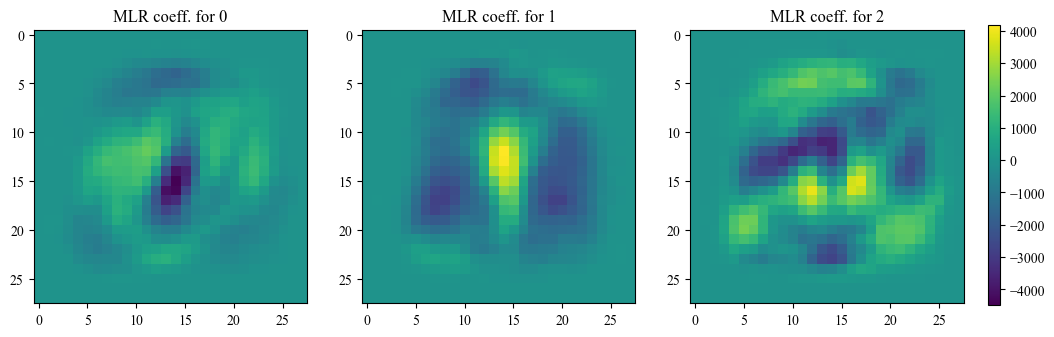

In [ ]:
# fit multiclass logistic regression using GD

list_digits=['0', '1', '2']
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST = [X,y])
# Feature matrix of size (p x n) = (feature dim x samples)


H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features
W = fit_MLR_GD(Y=y_train, H=H_train)
print('!! W.shape', W.shape)

# Get predicted probabilities
H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

print('!!! y_test.shape', y_test.shape)

print('!!! Q.shape', Q.shape)


results_dict = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q)
confusion_mx = results_dict.get('results_dict')

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_digits), figsize=[12, 4])
for i in np.arange(len(list_digits)):
    L = list_digits[i]
    im = ax[i].imshow(W[1:,i].reshape(28,28), vmin=np.min(W), vmax=np.max(W))
    ax[i].title.set_text("MLR coeff. for %s" % L )
    # ax[i].legend()
    # if i == len(list_digits) - 1:

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MLR_MNIST_ex1.pdf', bbox_inches='tight')


!!! confusion_mx [[   0 1356    0]
 [   0 1570    0]
 [   0 1350    0]]
!!! Accuracy 0.36716557530402244
!!! confusion_mx [[1037    0  319]
 [   2 1155  413]
 [  67   26 1257]]
!!! Accuracy 0.8065949485500468
!!! confusion_mx [[1019    0  337]
 [   2 1465  103]
 [  17   50 1283]]
!!! Accuracy 0.8809635173058934
!!! confusion_mx [[1289    0   67]
 [   1 1512   57]
 [  17   17 1316]]
!!! Accuracy 0.9628157156220767


C:\Users\giuli\AppData\Local\Temp\ipykernel_19340\3830841738.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


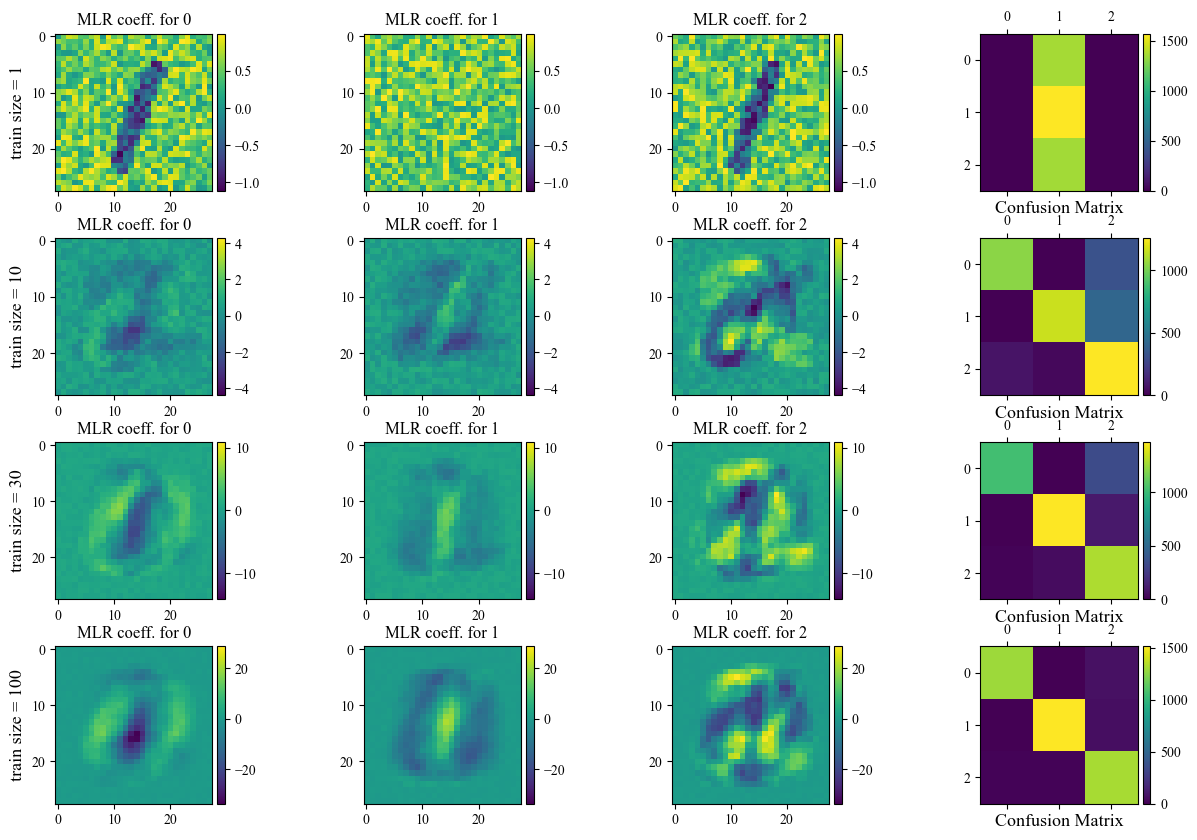

In [ ]:
# fit multiclass logistic regression using GD and compute multiclass classification accuracies

# Get train and test data
digits_list = ['0', '1', '2']
# digits_list = ['0', '1', '2', '3', '4']
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(digits_list, full_MNIST = [X,y])

# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx, :]

    # Train the multiclass logistic regression model
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features
    W = fit_MLR_GD(Y=y_train0, H=H_train0)
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop

    # Get predicted probabilities
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

    results_dict = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=len(list_train_size), ncols=len(digits_list)+1, figsize=[15, 10])
for i in np.arange(len(list_train_size)):
    for j in np.arange(len(digits_list)+1):
        if j < len(digits_list):
            L = digits_list[j]
            W = W_list[i]
            im = ax[i,j].imshow(W[1:,j].reshape(28,28), vmin=np.min(W), vmax=np.max(W))
            ax[i,j].title.set_text("MLR coeff. for %s" % L )
            if j == 0:
                ax[i,j].set_ylabel("train size = %i" % results_list[i].get("train size"), fontsize=13)
            divider = make_axes_locatable(ax[i,j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax)
        else:
            confusion_mx = results_list[i].get("confusion_mx")
            im_confusion = ax[i,j].matshow(confusion_mx)
            # ax[i,j].set_title("Confusion Matrix")
            ax[i,j].set_xlabel("Confusion Matrix", fontsize=13)
            # ax[i].legend()
            # if i == len(list_digits) - 1:
            divider = make_axes_locatable(ax[i,j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im_confusion, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('MLR_MNIST_test_ex2.pdf', bbox_inches='tight')


## Probit Regression

In [ ]:
# probit function
from scipy.stats import norm

def probit(x):
    return norm.cdf(x) # Yes, it is exactly the standard normal CDF.

In [ ]:
# plot probit and sigmoid function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,3])
x = np.linspace(-7, 7, 100)
ax.plot(x, sigmoid(x), color='blue', label="$y=\sigma(x)=\exp(x)/(1+\exp(x))$")
ax.plot(x, probit(x), color='red', label="$y=\psi(x)=Probit(x)$")
plt.axhline(y=1, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
ax.legend()
plt.savefig('probit_ex.pdf', bbox_inches='tight')

In [ ]:
def fit_PR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Probit Regression using Gradient Descent
        Y = (n x 1), H = (p x n) (\Phi in lecture note), W = (p x 1)
        Logistic Regression: Y ~ Bernoulli(Q), Q = Probit(H.T @ W)
        '''
        if W0 is None:
            W0 = 1-2*np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize from [-1,1]

        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [ ]:
# plot fitted probit regression curve
digit_list_list = [['0','1'],['0','7'],['2','3'],['2', '8']] # list of list of two digits
# fit LR for each cases
W_array = []
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=L, full_MNIST = [X,y], noise_rate=0.5)
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features

    W = fit_PR_GD(Y=y_train, H=H_train/1000)
    W = fit_PR_GD(Y=y_train, H=H_train/1000)
    W_array.append(W.copy())

W_array = np.asarray(W_array)


# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(digit_list_list), figsize=[16, 4])
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    W = W_array[i]
    im = ax[i].imshow(W[1:,:].reshape(28,28), vmin=np.min(W_array), vmax=np.max(W_array))
    ax[i].title.set_text("LR coeff. for %s vs. %s" % (L[0], L[1]))
    # ax[i].legend()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_training_ex.pdf', bbox_inches='tight')

In [ ]:
# fit probit regression using GD and compute binary classification accuracies

# Get train and test data
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST(digits_list, full_MNIST = [X,y], noise_rate=0.5)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features
    W = fit_PR_GD(Y=y_train0, H=H_train0/100)  # reduce the scale of H for numerical stability
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop

    # Get predicted probabilities
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

    # Print out the results
    """
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred']:
            print('%s = %f' % (key, results_dict.get(key)))
    """

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:]
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))

    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))

    ax[i].set_title('Opt. regression coeff.', fontsize=13)
    ax[i].set_xlabel(subtitle, fontsize=20)

fig.subplots_adjust(right=0.9)
fig.suptitle("MNIST Binary Classification by LR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex1.pdf', bbox_inches='tight')